In [ ]:
!pip install keras-tuner -q 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError
import keras_tuner as kt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [ ]:
#df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [ ]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [ ]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [ ]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [ ]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [ ]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [ ]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [ ]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [ ]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [ ]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# Split dataset into training, validation and testing datasets

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I'll be splitting the data into three sets (Training, Validation and Test)  as per the holdout method to help with determining the generalisation ability of the model during model selection. 
#### 61.45% of the data will be used for training, 12.7% will be used as the validation set and the remaining 25.85% will be used as the test set

In [ ]:
split = int(len(df)*0.6145)
training_set = df[:split]      # 17/8/2017 - 31/12/2019

subset = df[split:]
split2 = int(len(subset)*0.3303)

val_set = subset[:split2]      # 1/1/2020 - 28/6/2020
test_set = subset[split2:]     # 29/6/2020 - 28/6/2021

In [ ]:
print('Training: ', training_set.shape, '\nValidation: ', val_set.shape, '\nTest: ', test_set.shape)

Training:  (867, 5) 
Validation:  (180, 5) 
Test:  (365, 5)


# Split the data into X and y variables

In [ ]:
# the x values will contain all the features in the dataset and the y value will contain only the target feature to predict (Close Price) 

X_training = (training_set.iloc[:, :]).values.reshape(training_set.shape[0],training_set.shape[1])
y_training = (training_set.iloc[:, 4]).values.reshape(training_set.shape[0],1)

print(X_training.shape, y_training.shape)

X_valid = (val_set.iloc[:, :]).values.reshape(val_set.shape[0],val_set.shape[1])
y_valid = (val_set.iloc[:, 4]).values.reshape(val_set.shape[0],1)

print(X_valid.shape, y_valid.shape)

X_testing = (test_set.iloc[:, :]).values.reshape(test_set.shape[0],test_set.shape[1])
y_testing = (test_set.iloc[:, 4]).values.reshape(test_set.shape[0],1)

print(X_testing.shape, y_testing.shape)

(867, 5) (867, 1)
(180, 5) (180, 1)
(365, 5) (365, 1)


# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler from scikit-learn to do this.
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [ ]:
Xscaler = MinMaxScaler(feature_range=(0,1))
yscaler = MinMaxScaler(feature_range=(0,1))

X_train = Xscaler.fit_transform(X_training)
y_train = yscaler.fit_transform(y_training)

X_val = Xscaler.fit_transform(X_valid)
y_val = yscaler.fit_transform(y_valid)

X_test = Xscaler.fit_transform(X_testing)
y_test = yscaler.fit_transform(y_testing)

## Prepare data for multi-step LSTM
##### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [ ]:
# stack the data horizontally

train_stacked = np.hstack((X_train, y_train))
print ("Stacked Training Data Shape: " , train_stacked.shape)

val_stacked = np.hstack((X_val, y_val))
print ("Stacked Validation Data Shape: " , val_stacked.shape)

test_stacked = np.hstack((X_test, y_test))
print ("Stacked Test Data Shape: " , test_stacked.shape)

Stacked Training Data Shape:  (867, 6)
Stacked Validation Data Shape:  (180, 6)
Stacked Test Data Shape:  (365, 6)


In [ ]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [ ]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 7

# run function
X_train, y_train = create_sequences(train_stacked, n_steps_in, n_steps_out)
print ("X train sequences: " , X_train.shape, "y train sequences" , y_train.shape)            

X_val, y_val = create_sequences(val_stacked, n_steps_in, n_steps_out)
print ("X val sequences: " , X_val.shape, "y val sequences" , y_val.shape) 

X_test, y_test = create_sequences(test_stacked, n_steps_in, n_steps_out)
print ("X test sequences: " , X_test.shape, "y test sequences" , y_test.shape)      

X train sequences:  (848, 14, 5) y train sequences (848, 7)
X val sequences:  (161, 14, 5) y val sequences (161, 7)
X test sequences:  (346, 14, 5) y test sequences (346, 7)


# Model Building on CoLab
### I will tune the model using Keras Tuner

##### https://www.danielpovey.com/files/2017_interspeech_dropout.pdf 
##### https://www.tensorflow.org/tutorials/keras/keras_tuner#define_the_model

In [ ]:
n_features = X_train.shape[2]

rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

# I need to define the features during model creation so that the Keras Tuner can find the optimum values

# create LSTM model
def build_model(hp):

  model = Sequential()
  # Tuner for number of nodules/units in the model layers
  model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))

  for i in range(hp.Int('n_layers', 1, 3)):  # adding variation of layers.
    model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True))
    model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))

  model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu'))
  model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))
  model.add(Dense(n_steps_out))
  model.compile(loss='mse' , optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])) , metrics=[rmse, mae])

  return model


# Hypertune the model

In [ ]:
# I need to set up the tuner with the correct objective function which in this case is to minimise the validation loss (i.e. the generalisation error)

tuner1 = kt.RandomSearch(build_model,
                     objective = kt.Objective("val_loss", direction="min"),
                     max_trials=10)

# Search for the best parameters

In [ ]:
tuner1.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dropout (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5, 0.7], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# The tuner will now search across the potential values for each hyperparameter and select the best combination

tuner1.search(X_train , y_train , epochs=100 , validation_data=(X_val, y_val)  ,shuffle=False, callbacks=[stop_early])

Trial 10 Complete [00h 00m 25s]
val_loss: 0.03728898987174034

Best val_loss So Far: 0.027118448168039322
Total elapsed time: 00h 05m 50s
INFO:tensorflow:Oracle triggered exit


# Results of hypertuning

In [ ]:
# This will provide a list of the top 10 best models in ascending order, with their respective parameters. 
# Model 1 at the top of the list is the optimised model that I will use for training and testing.

tuner1.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 80
n_layers: 1
dropout: 0.3
learning_rate: 0.001
Score: 0.027118448168039322
Trial summary
Hyperparameters:
units: 70
n_layers: 2
dropout: 0.3
learning_rate: 0.001
Score: 0.03728898987174034
Trial summary
Hyperparameters:
units: 30
n_layers: 3
dropout: 0.3
learning_rate: 0.001
Score: 0.041735440492630005
Trial summary
Hyperparameters:
units: 40
n_layers: 2
dropout: 0.3
learning_rate: 0.001
Score: 0.045965395867824554
Trial summary
Hyperparameters:
units: 90
n_layers: 3
dropout: 0.7
learning_rate: 0.001
Score: 0.05506626144051552
Trial summary
Hyperparameters:
units: 40
n_layers: 1
dropout: 0.3
learning_rate: 0.01
Score: 0.0916093960404396
Trial summary
Hyperparameters:
units: 20
n_layers: 1
dropout: 0.3
learning_rate: 0.01
Score: 0.13688576221466064
Trial summary
Hyperparameters:
units: 70
n_layers: 1
dropout: 0.5
learning_rate: 0.01
Sco

In [ ]:
# best model - we still need to find the best number of epochs though
best_model_history = tuner1.get_best_models(num_models=1)[0]

In [ ]:
best_model_history.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 80)            27520     
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 80)            51520     
_________________________________________________________________
dropout (Dropout)            (None, 14, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 567       
Total params: 131,127
Trainable params: 131,127
Non-trainable params: 0
__________________________________________________

# Find optimal epochs by training the best model with the best hyperparameters

In [ ]:
find_epoch = best_model_history.fit(X_train , y_train , epochs=100 , validation_data=(X_val, y_val) ,shuffle=False, verbose = 0)

In [ ]:
val_loss_per_epoch = find_epoch.history['val_loss']    # want to find where the gap between train loss and val loss is minimal
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Best epoch: 61


# Re-train model to get final results
#### The training will be repeated 5 times for robustness
#### source code: https://github.com/yanghaocsg/keras_lstm/wiki/chapter-7.1-Evaluating-LSTM-Models-Robustly

In [ ]:
best_model = tuner1.get_best_models(num_models=1)[0]

training_losses = pd.DataFrame()
validation_losses = pd.DataFrame()

training_rmse = pd.DataFrame()
validation_rmse = pd.DataFrame()

training_mae = pd.DataFrame()
validation_mae = pd.DataFrame()

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  history = best_model.fit(X_train , y_train , epochs=best_epoch , verbose=0 , validation_data=(X_val, y_val) ,shuffle=False)

  training_losses[str(i)] = history.history['loss']
  validation_losses[str(i)] = history.history['val_loss']

  training_rmse[str(i)] = history.history['root_mean_squared_error']
  validation_rmse[str(i)] = history.history['val_root_mean_squared_error']

  training_mae[str(i)] = history.history['mean_absolute_error']
  validation_mae[str(i)] = history.history['val_mean_absolute_error']


Training Number  0

Training Number  1

Training Number  2

Training Number  3

Training Number  4


In [ ]:
# Retrieve results to get an average value of each

avg_trainloss_list = []
avg_valloss_list= []

avg_trainrmse_list = []
avg_valrmse_list= []

avg_trainmae_list = []
avg_valmae_list = []

for i in range(5):

  final_train_loss = training_losses.iloc[-1,i]
  final_val_loss = validation_losses.iloc[-1,i]
  avg_trainloss_list.append(final_train_loss)
  avg_valloss_list.append(final_val_loss)

  final_train_rmse = training_rmse.iloc[-1,i]
  final_val_rmse = validation_rmse.iloc[-1,i]
  avg_trainrmse_list.append(final_train_rmse)
  avg_valrmse_list.append(final_val_rmse)
  
  final_train_mae = training_mae.iloc[-1,i]
  final_val_mae = validation_mae.iloc[-1,i]
  avg_trainmae_list.append(final_train_mae)
  avg_valmae_list.append(final_val_mae)

print('Average Training Loss: ', float('%.3g' % np.mean(avg_trainloss_list)), ' ||  Average Validation Loss: ', float('%.3g' % np.mean(avg_valloss_list)))
print('Average Training RMSE: ', float('%.3g' % np.mean(avg_trainrmse_list)), ' ||  Average Validation RMSE: ', float('%.3g' % np.mean(avg_valrmse_list)))
print('Average Training MAE: ', float('%.3g' % np.mean(avg_trainmae_list)), ' ||  Average Validation MAE: ', float('%.3g' % np.mean(avg_valmae_list)))


Average Training Loss:  0.00328  ||  Average Validation Loss:  0.0221
Average Training RMSE:  0.0569  ||  Average Validation RMSE:  0.146
Average Training MAE:  0.0376  ||  Average Validation MAE:  0.111


# Test the model on test dataset

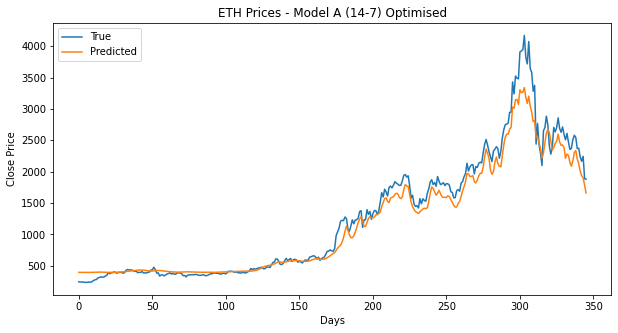


Testing Loss:  0.0037  ||  Testing RMSE:  0.0608  ||  Testing MAE:  0.0392


In [ ]:
y_test_inv = yscaler.inverse_transform(y_test)
  
# generate the test predictions and plot them against the true values

test_pred = best_model.predict(X_test)
test_pred = yscaler.inverse_transform(test_pred)

plt.figure(figsize = (10, 5))
plt.plot(y_test_inv[:,0], label = 'True')
plt.plot(test_pred[:,0], label = 'Predicted')
plt.legend()
plt.title('ETH Prices - Model A (14-7) Optimised')
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.show()

# generate the loss and rmse

test_loss, test_rmse, test_mae = best_model.evaluate(X_test, y_test, verbose = 0)

print('\nTesting Loss: ', float('%.3g' % test_loss), ' ||  Testing RMSE: ', float('%.3g' % test_rmse), ' ||  Testing MAE: ', float('%.3g' % test_mae))


In [ ]:
# saving the model so that it can be loaded in a later notebook to compare against the models with different inputs

best_model.save('/content/drive/My Drive/Different Inputs/LSTM_Model_A')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Different Inputs/LSTM_Model_A/assets
